In [181]:
# Import packages and set up
import numpy as np
from matplotlib import pyplot as plt
import rospy
import cv2
from cv_bridge import CvBridge
from sensor_msgs.msg import CompressedImage, Image
import pyrosbag as prb
import jupyros as jr
from cv_bridge.boost.cv_bridge_boost import getCvType
import csv
%matplotlib inline

In [2]:
# ROS stuff (roscore needs to be running to proceed)
rospy.init_node('extrinsic_calibration', anonymous=True)
br = CvBridge()
therm_pub = rospy.Publisher("thermal/camera/processed", Image, queue_size=1)
color_pub = rospy.Publisher("color/camera/processed", Image, queue_size=1)

In [123]:
# Input
times = [1592951264, 1592951290, 1592951333]

# Auxiliary
therm_times_index = 0
color_times_index = 0
therm_frames = []
color_frames = []
therm_ready_to_record = False
color_ready_to_record = False

In [124]:
def record_frame(stamp, source):
    global therm_times_index, color_times_index, therm_ready_to_record, color_ready_to_record
    if source == 'therm':
        if therm_times_index < len(times):
            if stamp.secs > times[therm_times_index] and not therm_ready_to_record:
                therm_times_index += 1
                therm_ready_to_record = True
                print('Therm at', stamp.secs)
                return True
    elif source == 'color':
        if color_times_index < len(times):
            if stamp.secs > times[color_times_index] and not color_ready_to_record:
                color_times_index += 1
                color_ready_to_record = False
                print('Color at', stamp.secs)
                return True
    else:
        return False

In [178]:
blur_window = 3
intensity_threshold = 140
kernel = np.ones((3,3),np.uint8)

def comp_to_cv2(msg):
    return br.compressed_imgmsg_to_cv2(msg)

def process_thermal(im):
    '''
    Returns image with calibration plate segmented out as a binary mask
    '''
#     im = br.compressed_imgmsg_to_cv2(msg)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    mean = cv2.mean(im)
    im = cv2.blur(im, (blur_window, blur_window))
    _, thresh = cv2.threshold(im, intensity_threshold, 255, cv2.THRESH_BINARY)
    return thresh

def process_color(im):
    '''
    Returns image with calibration plate segmented out as a binary mask
    '''
#     im = br.compressed_imgmsg_to_cv2(msg)
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
#     low = ((75,30,160)) #20/255.*180., 45
#     high = ((130,128,255))    
    low = ((75,30,160)) #20/255.*180., 45
    high = ((130,128,255))        
    im = cv2.inRange(im, low, high)
    im = cv2.blur(im, (blur_window, blur_window))
    
    return im

In [126]:
def therm_clbk(msg):
    global therm_frames, therm_ready_to_record
    processed_therm = comp_to_cv2(msg)
    if record_frame(msg.header.stamp, 'therm'):
        therm_frames.append(processed_therm)
        therm_ready_to_record = False
    
def color_clbk(msg):
    global color_frames, color_ready_to_record
    processed_color = comp_to_cv2(msg)
    if record_frame(msg.header.stamp, 'color'):
        color_frames.append(processed_color)
        color_ready_to_record = False

In [127]:
jr.subscribe("thermal/camera/image_raw_throttle/compressed", CompressedImage, therm_clbk)
jr.subscribe("color/camera/image_raw_throttle/compressed", CompressedImage, color_clbk)
with prb.BagPlayer("/home/ed/Data/2020-06-23-15-27-00_test/2020-06-23-15-27-21_0.bag") as example:
    example.play(publish_rate_multiplier=50.0)
    while example.is_running:
        pass 

Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now


Therm at 1592951265
Therm at 1592951291
Color at 1592951265
Therm at 1592951334
Color at 1592951322


3 2


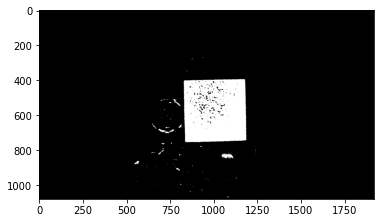

Color at 1592951334


In [180]:
# plt.imshow(color_frames[0], cmap='gray')
print(len(therm_frames), len(color_frames))
plt.imshow(process_color(color_frames[0]), cmap='gray')


In [172]:
# Binary mask --> contour --> corner points --> min area rect
def get_corner_points(im):
    '''
    Input image is a binary mask
    '''
    contour = np.array(cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0])
#     assert len(contour) == 1
    return cv2.minAreaRect(contour[0])

In [44]:
# For each square configuration
# extract the 4 corners of the square

therm_coords = []
color_coords = []

for i in range(len(times)):
    therm_coords.append(get_corner_points(therm_frames[i]))
    color_coords.append(get_corner_points(color_frames[i]))

AssertionError: 

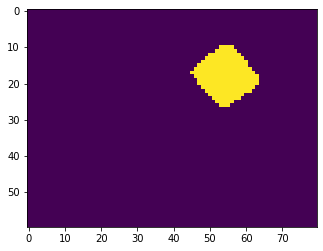

In [34]:
plt.imshow(therm_frames[2])

In [188]:
# https://yangcha.github.io/iview/iview.html to pick indiv pixels
therm_coords = []
color_coords = []

with open('/home/ed/Data/2020-06-23-15-27-00_test/color.csv', 'r') as f:
    data = csv.reader(f)
    for row in data:
        color_coords.append([int(row[0]), int(row[1]), 1.0])
        
with open('/home/ed/Data/2020-06-23-15-27-00_test/therm.csv', 'r') as f:
    data = csv.reader(f)
    for row in data:
        therm_coords.append([int(row[0]), int(row[1]), 1.0])     

In [189]:
therm_coords = np.transpose(np.array(therm_coords))
color_coords = np.transpose(np.array(color_coords))
print (therm_coords.shape, color_coords.shape)

(3, 12) (3, 12)


In [194]:
T_therm_color = np.dot(therm_coords,np.linalg.pinv(color_coords))
T_color_therm = np.linalg.inv(T_therm_color)
np.set_printoptions(precision=3, suppress=True)
print (T_therm_color)
print (T_color_therm)

[[  0.066  -0.001 -29.8  ]
 [ -0.001   0.067  -1.357]
 [  0.      0.      1.   ]]
[[ 15.268   0.147 455.167]
 [  0.267  14.969  28.269]
 [ -0.     -0.      1.   ]]
